# Random forest for pianist classification

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from joblib import Parallel, delayed

from src import utils
from src.features.features_utils import PhaseCorrection, BeatUpbeatRatio, IOIComplexity, TempoSlope, ProportionalAsynchrony, RollingIOISummaryStats
from src.detect.detect_utils import OnsetMaker
from src.visualise.random_forest_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 250

In [3]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Define predictor and prediction variables, get mappings

In [4]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [5]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
    'Feel': ['piano_bass_prop_async_nanmean', 'piano_drums_prop_async_nanmean', 'piano_bass_prop_async_nanstd', 'piano_drums_prop_async_nanstd'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_piano_drums', 'coupling_piano_bass'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope']
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

In [6]:
# This creates a dictionary for mapping a predictor onto its category
CATEGORY_MAPPING = {}
for pred in PREDICTORS:
    for category in PREDICTORS_CATEGORIES.keys():
        if pred in PREDICTORS_CATEGORIES[category]:
            CATEGORY_MAPPING[pred] = category

## Load in data

First, we load in our list of `src.detect.detect_utils.OnsetMaker` classes. These contain the location of detected onsets and beats, as well as additional metadata.

In [7]:
onsets: list[OnsetMaker] = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Extract features

Now, we can extract our desired feature from each OnsetMaker class.

In [8]:
def get_feature_data(feature_cls, cols, extra_str = '', **cls_kwargs):
    """Creates a class with given kwargs and returns the desired key-value pairs from its summary dictionary"""
    cls = feature_cls(**cls_kwargs)
    return {k + extra_str: v for k, v in cls.summary_dict.items() if k in cols}

In [9]:
def process_track(track: OnsetMaker) -> dict:
    """Processes a single track, extracting all required features, and returns a dictionary"""
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    # These are the positions of downbeats, i.e. the first beat of a measure
    downbeats = track.ons['downbeats_manual']
    # The tempo and time signature of the track
    tempo = track.tempo
    time_signature = track.item['time_signature']
    # Subset to get my onsets and partner onsets as separate dataframes
    my_onsets = track.ons[EXOG_INS]
    my_beats = summary_dict[EXOG_INS]
    their_beats = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != EXOG_INS]]
    # BEAT-UPBEAT RATIO
    bur = get_feature_data(
        BeatUpbeatRatio, ['bur_log_mean', 'bur_log_std', 'bur_log_count_nonzero'],
        my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True
    )
    # PHASE CORRECTION
    pc = get_feature_data(
        PhaseCorrection, ['self_coupling', 'coupling_bass', 'coupling_drums', 'nobs'],
        my_beats=my_beats, their_beats=their_beats, order=1
    )
    # PHASE CORRECTION - PARTNER
    # In comparison to the 'full' phase correction model, we only need to get a few columns here
    pcb = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_bass',
        my_beats=summary_dict['bass'], their_beats=summary_dict[['piano', 'drums']], order=1
    )
    pcd = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_drums',
        my_beats=summary_dict['drums'], their_beats=summary_dict[['piano', 'bass']], order=1
    )
    # PROPORTIONAL ASYNCHRONY
    pa = get_feature_data(
        ProportionalAsynchrony, ['piano_prop_async_count_nonzero', 'piano_bass_prop_async_nanmean', 'piano_drums_prop_async_nanmean', 'piano_bass_prop_async_nanstd', 'piano_drums_prop_async_nanstd'],
        summary_df=summary_dict, my_instr_name=EXOG_INS
    )
    # IOI COMPLEXITY
    ioi = get_feature_data(
        IOIComplexity, ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
        my_onsets=my_onsets, downbeats=downbeats, tempo=tempo, time_signature=time_signature
    )
    # TEMPO SLOPE
    ts = get_feature_data(
        TempoSlope, ['tempo_slope', 'tempo_drift'],
        my_beats=pd.concat([my_beats, their_beats], axis=1).mean(axis=1)
    )
    # TEMPO STABILITY
    tstab = get_feature_data(
        RollingIOISummaryStats, ['rolling_std_count_nonzero', 'rolling_std_median'],
        my_onsets=my_beats, downbeats=downbeats, bar_period=4
    )
    # Return a single dictionary that combines the summary dictionary for all the features
    return dict(**track.item, **bur, **pc, **pcb, **pcd, **pa, **ioi, **ts, **tstab, tempo=tempo)

Now, we extract features from all tracks in parallel (should take < 5 minutes)

In [10]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    res = parallel(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [11]:
df = pd.DataFrame(res).sort_values('pianist').reset_index(drop=True)

In [12]:
df.head()

,track_name,album_name,recording_year,pianist,channel_overrides,mbz_id,notes,time_signature,first_downbeat,rating_bass_audio,rating_bass_detection,rating_drums_audio,rating_drums_detection,rating_mix,rating_piano_audio,rating_piano_detection,rating_comments,has_annotations,links,excerpt_duration,timestamps,log,musicians,photos,fname,bur_log_mean,bur_log_std,bur_log_count_nonzero,coupling_bass,coupling_drums,self_coupling,nobs,coupling_piano_bass,nobs_bass,coupling_piano_drums,nobs_drums,piano_prop_async_count_nonzero,piano_bass_prop_async_nanmean,piano_drums_prop_async_nanmean,piano_bass_prop_async_nanstd,piano_drums_prop_async_nanstd,lz77_mean,lz77_std,n_onsets_mean,n_onsets_std,tempo_slope,tempo_drift,rolling_std_median,rolling_std_count_nonzero,tempo
0,Poor Butterfly,Complete Live at the Pershing Lounge 1958,1958,Ahmad Jamal,{},94f90cba-f3c7-4a05-b86a-e30fd9ebe989,rim clicks have to be sticks,4,6.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,00:50,"{'start': '02:17', 'end': '03:07'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-poorbutterfly-crosbyifournierv-1958-94f...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030976,0.058693,NaN,0,140.064796
1,Tranquility,Tranquility,1967,Ahmad Jamal,{'bass': 'l'},4cc954d6-1e00-4bfd-b0e3-d12d2b5f853b,,4,15.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,04:36,"{'start': '02:01', 'end': '06:37'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Jamil N...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-tranquility-nasserjgantf-1967-4cc954d6,0.188277,0.912414,155,0.187913,0.784486,-0.523532,256.0,0.092367,306.0,0.093327,421.0,487,0.005624,0.014426,0.001091,0.008556,12.251613,1.577412,32.819355,6.372089,0.007916,0.003653,0.222142,155,138.603562
2,Where Are You,In Search of Momentum 110,2002,Ahmad Jamal,{},a1295aa8-78ab-4234-a8a9-f05c1916d2d8,,4,8.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,03:06,"{'start': '01:24', 'end': '04:30'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'James C...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-whereareyou-cammackjmuhammadi-2002-a129...,0.229792,0.818012,131,0.235178,0.916245,-0.520223,89.0,0.081562,161.0,0.119725,202.0,355,0.008551,0.016082,0.005224,0.008087,11.174242,1.943854,25.507576,7.448035,-0.014056,0.009137,0.222306,132,175.652227
3,I Didnt Know What Time It Was,Emerald City Nights Live At The Penthouse 1965...,1966,Ahmad Jamal,{},d41671ba-f977-41b4-8108-8c4d17f54689,,4,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,04:03,"{'start': '03:54', 'end': '07:57'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Jamil N...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-ididntknowwhattime-nasserjlampkinc-1966...,0.108574,0.519236,41,0.116213,0.696361,-0.708782,9.0,0.123296,12.0,0.203917,22.0,161,0.010366,0.012084,0.003024,0.007217,6.783019,3.180311,11.311321,6.984831,0.032167,0.009975,0.120081,104,277.098382
4,Waltz for Debbie,Live at Bubbas,1980,Ahmad Jamal,{},0c9b07cd-2553-4899-8451-fcd74a53a739,,4,12.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,02:00,"{'start': '03:10', 'end': '05:10'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Sabu Ad...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-waltzfordebbie-adeyolascrossleyp-1980-0...,0.562737,0.751594,23,NaN,NaN,NaN,NaN,NaN,NaN,-0.000092,1.0,55,0.003133,0.015614,-0.021554,0.011918,6.659091,3.443519,12.659091,8.476899,0.118093,0.017419,0.135465,36,195.038462


## Plot correlations between features
Before we clean outliers, we should plot the correlations between the raw values

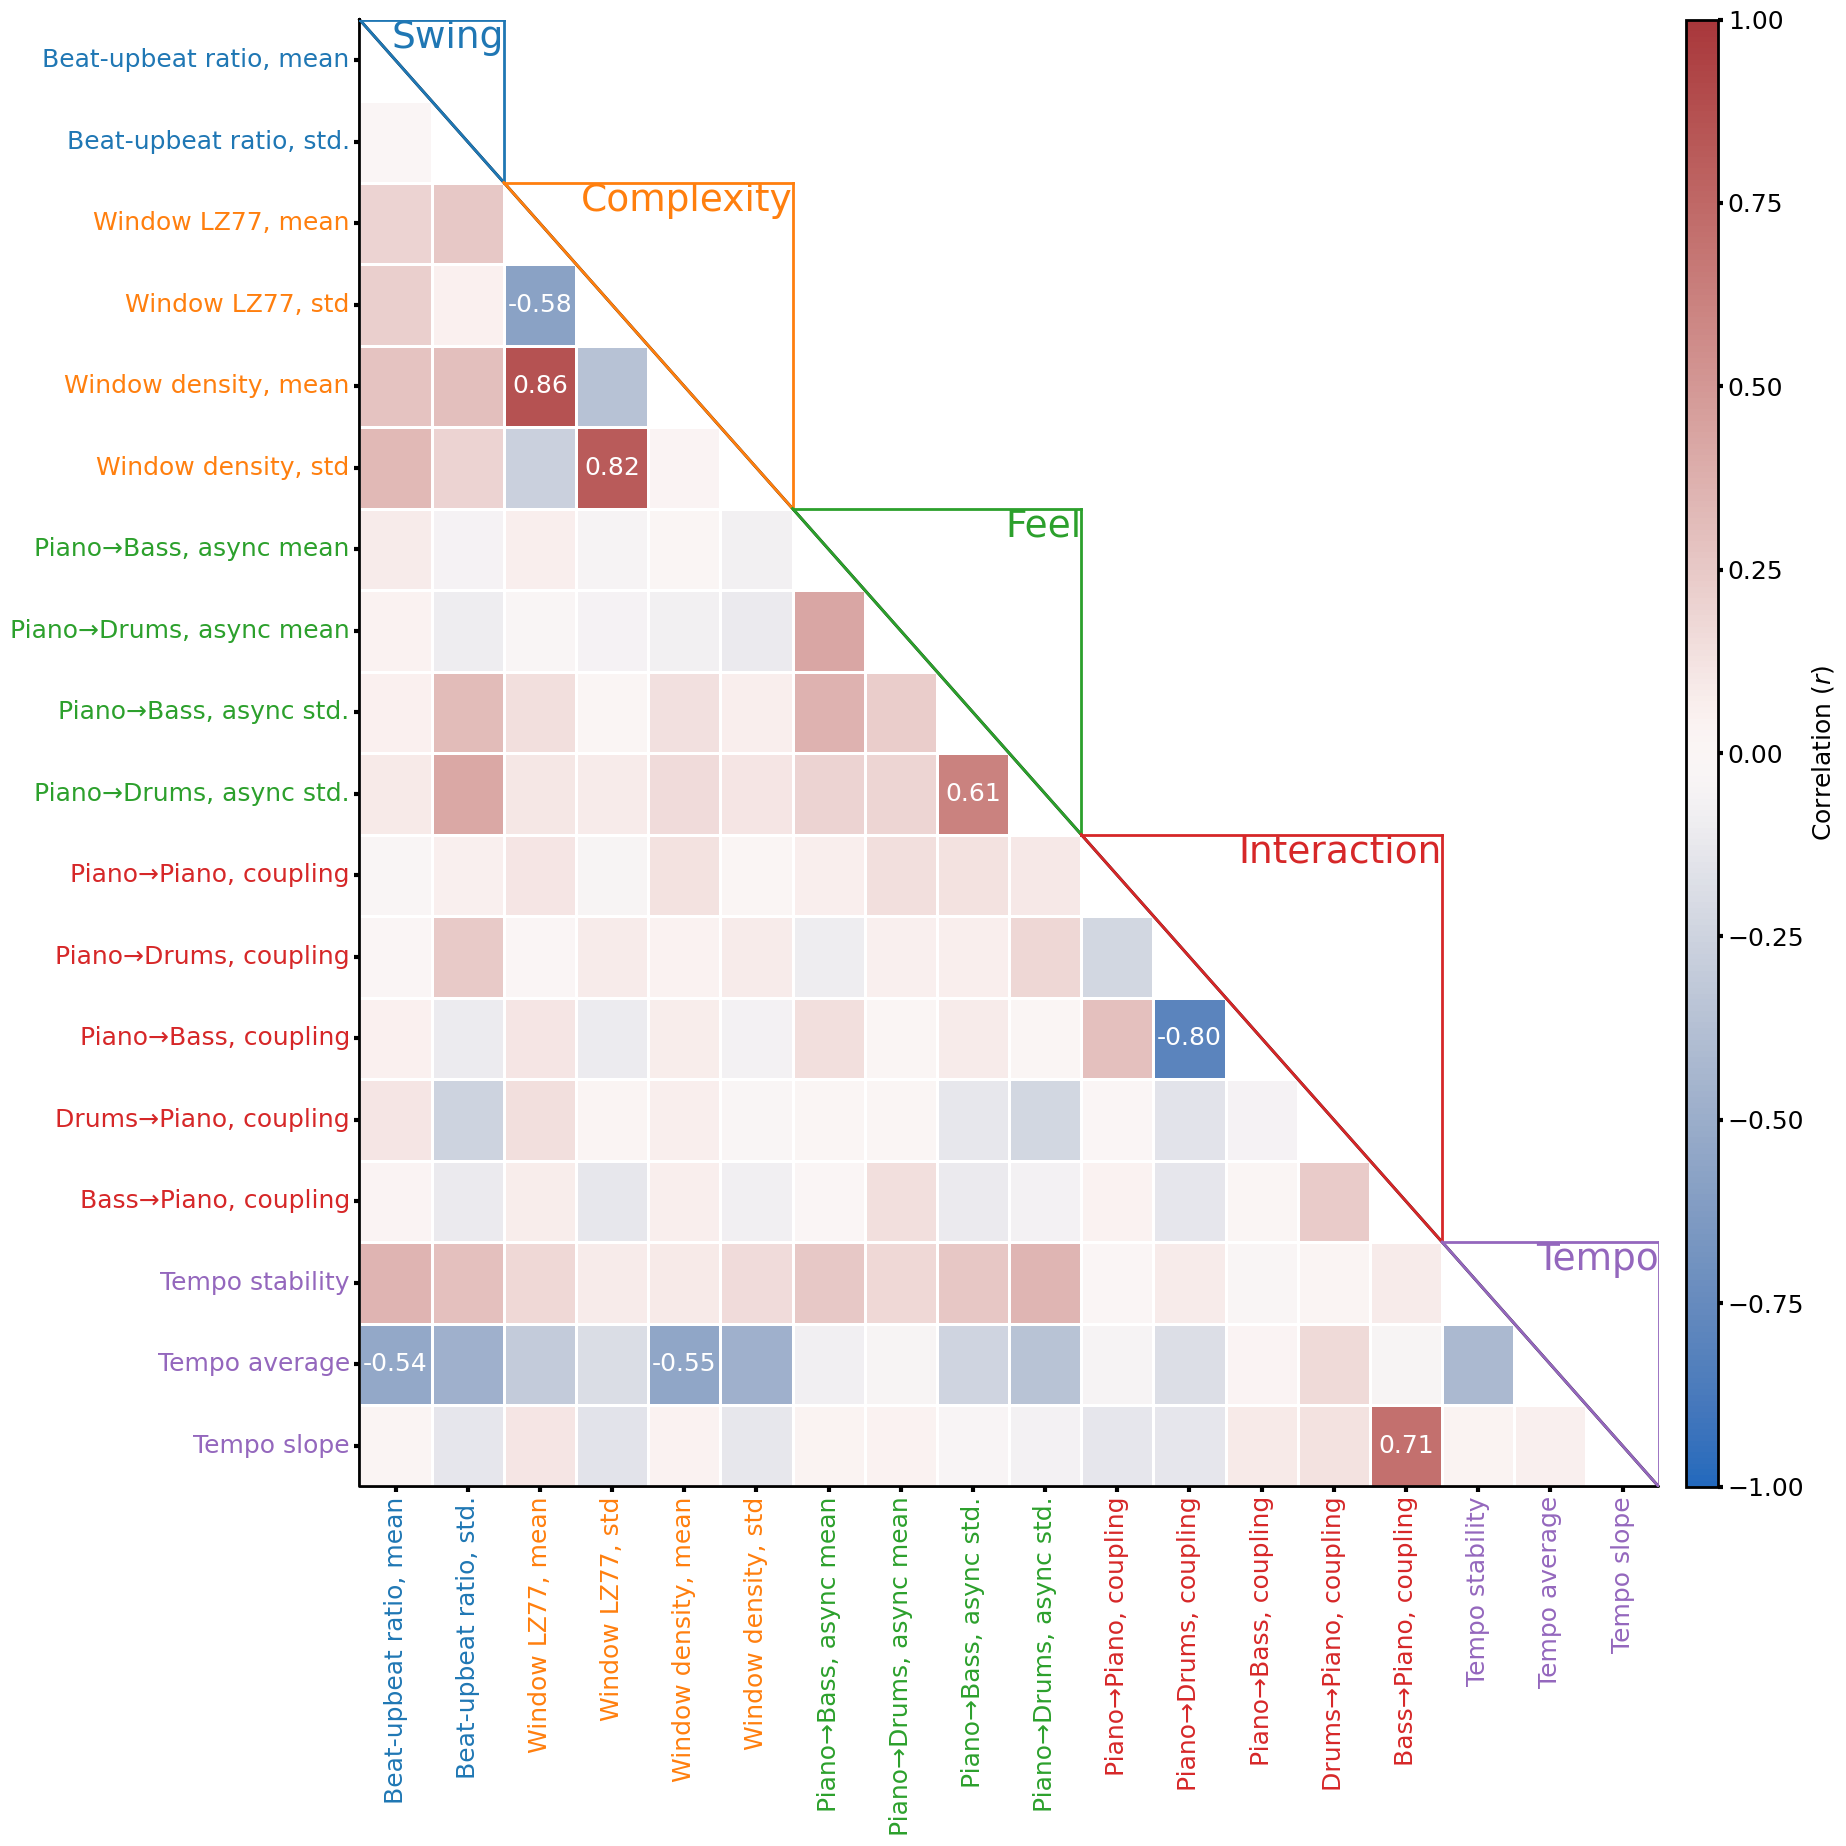

In [13]:
HeatMapFeatureCorrelation(df[PREDICTORS]).create_plot()
plt.show()

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features. We set outlying values to `np.nan` so that we can set them to the overall average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [14]:
clean = df.copy(deep=True)

In [15]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [16]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_piano_{col}'] = np.nan

We clean `bur_log_mean` and `bur_log)std` when `-2 <= average_bur <= 2` (these are the values discussed by Corcoran and Frieler) OR `bur_log_count_nonzero < 15` (we have fewer than 15 BURs in the track).

In [17]:
for col in ['bur_log_mean', 'bur_log_std']:
    clean.loc[clean['bur_log_mean'] < -2, col] = np.nan
    clean.loc[clean['bur_log_mean'] > 2, col] = np.nan
    clean.loc[clean['bur_log_count_nonzero'] < 15, col] = np.nan

We clean `bass/drums_prop_async` when `piano_prop_async_count_nonzero < 10`, i.e. we have fewer than 10 beat asynchronies

In [18]:
for col in ['bass', 'drums']:
    clean.loc[clean[f'piano_prop_async_count_nonzero'] < 10, f'piano_{col}_prop_async_nanmean'] = np.nan
    clean.loc[clean[f'piano_prop_async_count_nonzero'] < 10, f'piano_{col}_prop_async_nanstd'] = np.nan

We clean `tempo_slope` and `tempo_drift` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [19]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_drift'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [20]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

## Get number of missing values per predictor
Let's see how many missing values we have per predictor variable

In [21]:
clean[PREDICTORS].isna().sum()

bur_log_mean                       15
bur_log_std                        15
lz77_mean                           2
lz77_std                            2
n_onsets_mean                       2
n_onsets_std                        2
piano_bass_prop_async_nanmean      12
piano_drums_prop_async_nanmean      3
piano_bass_prop_async_nanstd       12
piano_drums_prop_async_nanstd       3
self_coupling                     128
coupling_drums                    128
coupling_bass                     128
coupling_piano_drums               71
coupling_piano_bass                95
rolling_std_median                  8
tempo                               0
tempo_slope                        24
dtype: int64

### Impute missing values based on feature average
We can now set missing values to the average for that feature across the entire dataset.

In [22]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())

Let's check that we've filled all missing values

In [23]:
print(X.isna().values.any())

False


### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [24]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling (new)
### Create the model class

In [25]:
class RandomForestFit:
    """Provides a wrapper around `StratifiedKFold` and `RandomForestClassifier`"""
    def __init__(self, params: dict = None):
        self.params = params if params is not None else {}
        # I think we can probably shuffle the data first.
        # The data is unordered (not time-series), so unlikely to have a negative effect
        self.skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        self.predicts, self.importances = [], []
        self.trees = []

    def fit_model(self, x_data, y_data):
        fits = [self._fit_model(x_data, y_data, x_idx, y_idx) for x_idx, y_idx in self.skf.split(x_data, y_data)]
        predicts, importances = list(zip(*fits))
        self.predicts = self._format_predicts_df(predicts)
        self.importances = self._format_importances_df(importances)
        return self

    def get_global_accuracy(self) -> float:
        """Returns the percentage of correct predictions"""
        return self.predicts['correct'].value_counts(normalize=True)[True]

    @staticmethod
    def _format_importances_df(importances) -> pd.DataFrame:
        importances_df_ = (
            pd.concat(importances, axis=1)
            .reset_index(drop=False)
            .rename(columns={'index': 'feature'})
        )
        importances_df_['category'] = importances_df_['feature'].map(CATEGORY_MAPPING)
        return importances_df_

    @staticmethod
    def _format_predicts_df(predicts) -> pd.DataFrame:
        predict_df_ = (
            pd.concat(predicts, axis=0)
            .sort_index()
            .rename(columns={0: 'prediction', 'pianist': 'actual'})
        )
        predict_df_['correct'] = predict_df_['prediction'] == predict_df_['actual']
        for var in ['prediction', 'actual']:
            predict_df_[var] = predict_df_[var].map({i: val for i, val in enumerate(pianist_labels)})
        return predict_df_

    def _fit_model(self, x_data, y_data, train_idx, test_idx):
        # Get our splits for this fold
        X_train, X_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        # Create the random forest model
        rf = RandomForestClassifier(random_state=SEED, **self.params)
        # Fit the random forest to the training data
        rf.fit(X_train, y_train)
        self.trees.append(rf)
        # Predict the test data
        y_predict = rf.predict(X_test)
        # Get prediction probabilities
        y_probs = rf.predict_proba(X_test)
        # Return the prediction and feature importance dataframes
        return (
            self._format_predict_df(y_predict, y_probs, y_test),
            pd.Series(rf.feature_importances_, index=X.columns)
        )

    @staticmethod
    def _format_predict_df(predict, predict_probs, actual):
        y_probs = pd.DataFrame(predict_probs)
        y_probs.columns = y_probs.columns.map({i: val for i, val in enumerate(pianist_labels)})
        y_probs.index = actual.index
        # Format the prediction series
        y_predict_s = pd.Series(predict)
        y_predict_s.index = actual.index
        # Concatenate the predicted and actual pianist
        return pd.concat([y_predict_s, actual, y_probs], axis=1)

### Get baseline accuracy
Here, we just guess a random pianist for each track

In [26]:
accuracy_random = accuracy_score(y, np.random.randint(y.min(), y.max(), len(y)))
print(f"Random guess accuracy: {accuracy_random}")

Random guess accuracy: 0.1


As you'd expect with 10 pianists and 30 tracks per pianist, we'll be correct approximately one in ten times if we just guess the pianist at random.

### Fit the initial model and get accuracy
Here we just use the default parameters for fitting the model

In [27]:
rf_init = RandomForestFit().fit_model(X, y)
print(f'Initial model accuracy: {rf_init.get_global_accuracy()}')

Initial model accuracy: 0.49333333333333335


### Parameter optimization
Now, we can try and optimize the model using a randomized search over an array of parameters

In [28]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(100, 2000, 10)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(10, 110, 10)]],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(1, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [65]:
# Create the `ParameterSampler` object for the required number of iterations
sampler = ParameterSampler(test_params, n_iter=N_ITER, random_state=SEED)

In [66]:
# Create the model wrappers with the given parameters (fast!)
rfs = [RandomForestFit(params=param) for param in sampler]
# Use lazy parallelization to fit the models to the data (slow!)
with Parallel(n_jobs=N_JOBS, verbose=11) as parallel:
    rfs_fitted = parallel(delayed(f.fit_model)(X, y) for f in rfs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

In [67]:
# Create a dataframe of parameters and accuracy scores
opt_df = pd.DataFrame([
    {'accuracy': md.get_global_accuracy(), 'n_iter': num, **param}
    for num, (md, param) in enumerate(zip(rfs_fitted, sampler), 1)
])
opt_df.head()

,accuracy,n_iter,n_estimators,max_features,max_depth,bootstrap
0,0.520000,1,50,log2,30.0,True
1,0.486667,2,950,log2,30.0,False
2,0.486667,3,550,log2,80.0,False
3,0.490000,4,750,sqrt,20.0,True
4,0.473333,5,150,None,60.0,True


In [187]:
# Get the parameter combination that yielded the best accuracy
best_params = opt_df[opt_df['accuracy'] == opt_df['accuracy'].max()][test_params.keys()].to_dict('records')[0]
best_params['max_depth'] = int(best_params['max_depth'])

`{'n_estimators': 50,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': True}`

### Fit the optimized model and get accuracy
Now, we use the best combination of parameters from our optimization process

In [28]:
rf_opt = RandomForestFit(params={'n_estimators': 50, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}).fit_model(X, y)
print(f'Optimized model accuracy: {rf_opt.get_global_accuracy()}')

Optimized model accuracy: 0.52


## Plot results
### Plot feature importance
Which rhythmic features are most important in defining the personal style of a particular pianist?

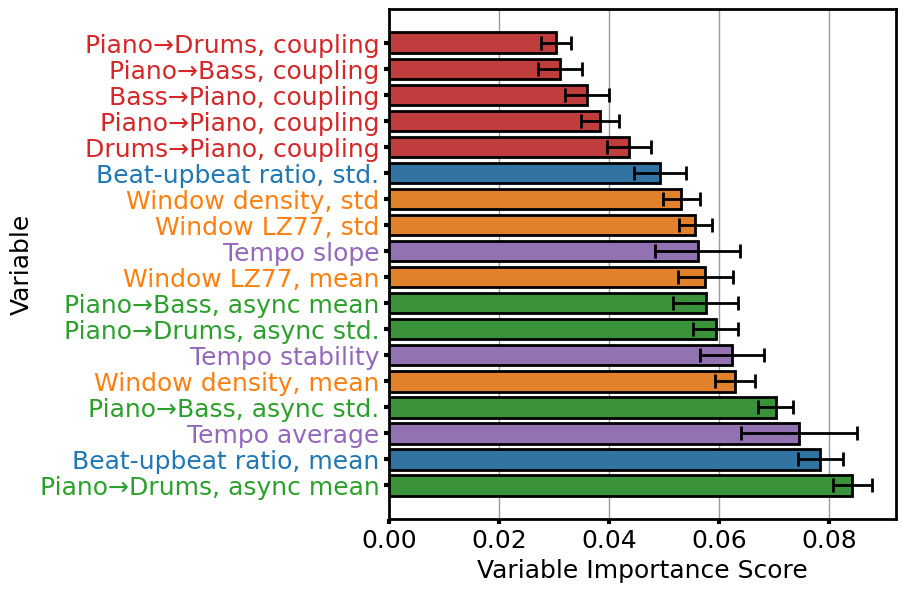

In [246]:
BarPlotFeatureImportances(rf_opt.importances).create_plot()
plt.show()

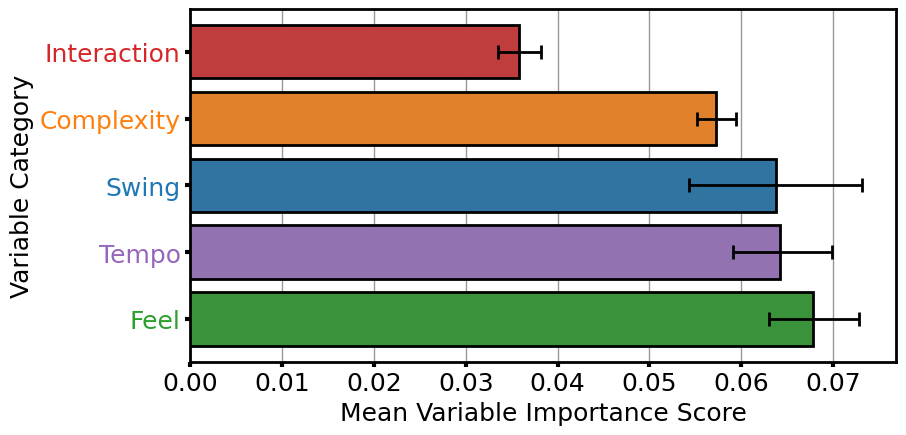

In [29]:
BarPlotCategoryImportances(rf_opt.importances).create_plot()
plt.show()

### Plot prediction errors by pianist
Which pianist's style is easiest to predict based on rhythmic features alone?

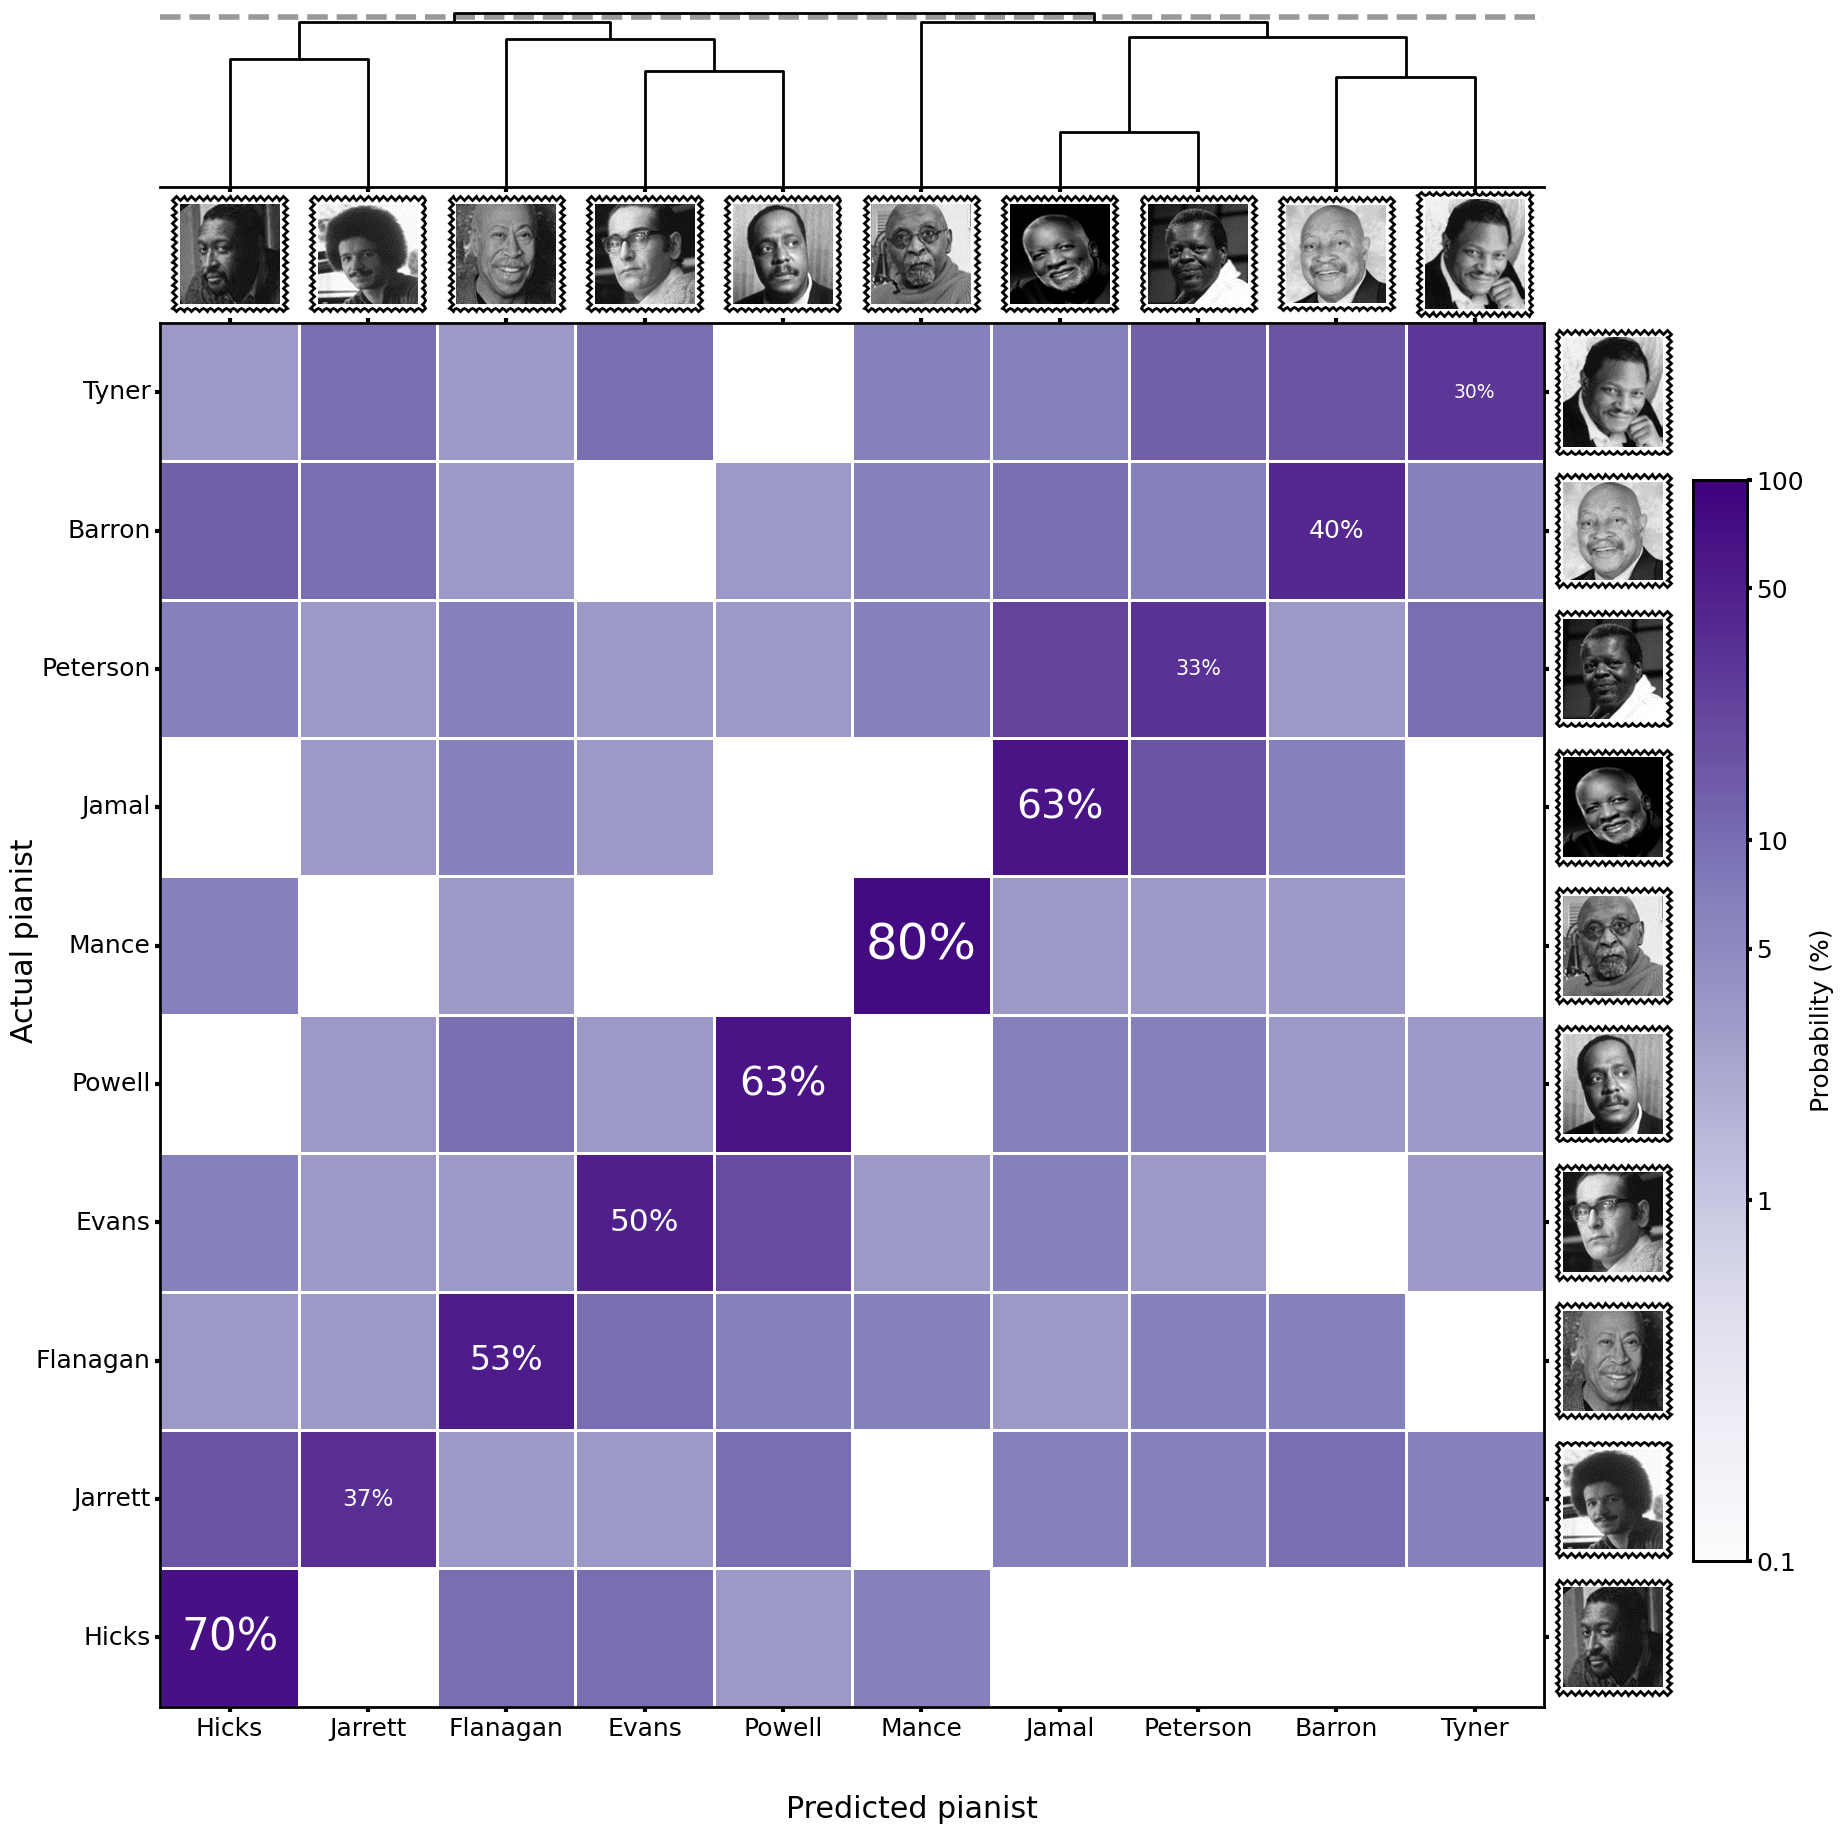

In [261]:
HeatMapPredictionProbDendro(rf_opt.predicts).create_plot()
plt.show()

### Get accuracy scores
Mean accuracy, top-k (`k=3`) accuracy, Cohen's kappa

In [ ]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score, cohen_kappa_score
act = rf_opt.predicts['actual'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
pred = rf_opt.predicts['prediction'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
probs = rf_opt.predicts[pianist_labels].values
print('Mean accuracy:', accuracy_score(act, pred))
print('Top-k accuracy:', top_k_accuracy_score(act, probs, k=3))
print('Cohen kappa:', cohen_kappa_score(act, pred))